In [ ]:
# import numpy as np
# import pickle
# import matplotlib.pyplot as plt
# from pathlib import Path
# from tqdm import trange

# import flygym.common
# import flygym.mujoco
# import flygym.mujoco.preprogrammed

In [51]:
from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.arena import FlatTerrain
from flygym.mujoco.examples.common import PreprogrammedSteps
from flygym.mujoco.examples.common import PreprogrammedSteps
import numpy as np
from IPython.display import Video
import matplotlib.pyplot as plt

In [52]:
class WindArena(FlatTerrain):
    def __init__(
        self,
        wind_vector=[-100.0, 0, 0],
        medium_density=0.01,
        medium_viscosity=0.01,
        **kwargs
    ):
        super().__init__(**kwargs)
        self._add_wind(wind_vector, medium_density, medium_viscosity)

    def _add_wind(self, wind_vector, medium_density, medium_viscosity):
        # Here I directly change the fields of the xml option element
        self.root_element.option.__setattr__("density", medium_density)
        self.root_element.option.__setattr__("viscosity", medium_viscosity)
        self.root_element.option.__setattr__("wind", wind_vector)


wind_arena = WindArena()

In [ ]:
#wind_nmf = NeuroMechFly(Parameters(render_camera="Animat/camera_front_zoomin", render_playspeed=0.02), arena=WindArena())

# run_total_time = 0.5
# target_num_steps = int(run_total_time / wind_nmf.timestep)

# preprogrammed_steps = PreprogrammedSteps()
# leg_action = []
# for leg in preprogrammed_steps.legs:
#     # fly is standing
#     leg_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))


# # run a simulation with wind
# for i in range(target_num_steps):
#     obs, reward, terminated, truncated, info = wind_nmf.step({"joints": leg_action})
#     wind_nmf.render()

In [53]:
from typing import Any, Dict, Tuple


class AristaNMF(NeuroMechFly):
    def _set_joints_stiffness_and_damping(self):
        for joint in self.model.find_all("joint"):
            if joint.name in self.actuated_joints:
                joint.stiffness = self.sim_params.joint_stiffness
                joint.damping = self.sim_params.joint_damping
            elif "Arista" in joint.name:
                joint.stiffness = 0.002
                joint.damping = 1e-5
            else:
                joint.stiffness = self.sim_params.non_actuated_joint_stiffness
                joint.damping = self.sim_params.non_actuated_joint_damping

    def _add_joint_sensors(self):
        self._arista_sensors = []

        for side in "LR":
            arista_sensor_joint = self.model.sensor.add(
                "jointpos", name=f"jointpos_{side}Arista", joint=f"joint_{side}Arista"
            )
            arista_sensor_torque = self.model.sensor.add(
                "jointactuatorfrc", name=f"jointactuatorfrc_{side}Arista", joint=f"joint_{side}Arista"
            )

            self._arista_sensors.append(arista_sensor_joint)
            self._arista_sensors.append(arista_sensor_torque)

        return super()._add_joint_sensors()
    
    # def _add_force_sensors(self):
    #     self._arista_sensors = []

    #     for side in "LR":
    #         arista_sensor = self.model.sensor.add(
    #             "jointactuatorfrc",
    #             name=f"force_{side}Arista",
    #             actuator=f"actuator_torque_{side}Arista",
    #         )

    #         self._arista_sensors.append(arista_sensor)

    #    return super()._add_force_sensors()


    def get_observation(self):
        obs = super().get_observation()
        arista_obs = self.physics.bind(self._arista_sensors).sensordata
        obs["arista_joint_pos"] = arista_obs.copy()
        return obs


arista_nmf = AristaNMF(Parameters())
arista_nmf._arista_sensors

[MJCF Element: <jointpos name="jointpos_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointactuatorfrc name="jointactuatorfrc_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointpos name="jointpos_RArista" joint="joint_RArista"/>,
 MJCF Element: <jointactuatorfrc name="jointactuatorfrc_RArista" joint="joint_RArista"/>]

In [41]:
preprogrammed_steps = PreprogrammedSteps()
leg_action = []
for leg in preprogrammed_steps.legs:
    # fly is standing
    leg_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))

In [54]:
obs_list = []

arista_nmf = AristaNMF(
    Parameters(render_camera="Animat/camera_front_zoomin", render_playspeed=0.1), arena = WindArena(), init_pose="stretch"
)
run_time = 0.5
target_num_steps = int(run_time / arista_nmf.timestep)
action = {"joints": leg_action}

# run a simulation and bend the abdomen
obs, info = arista_nmf.reset()
for i in range(target_num_steps):
    # # here, we simply use the recorded joint angles as the target joint angles
    obs, reward, terminated, truncated, info = arista_nmf.step(action)
    obs_list.append(obs)    
   

    arista_nmf.render()

arista_nmf.save_video("arista.mp4", 0)

In [43]:
Video("./arista.mp4")

In [46]:
obs_list[0].keys()

dict_keys(['joints', 'fly', 'contact_forces', 'end_effectors', 'fly_orientation', 'arista_joint_pos'])

In [59]:
arista_joint = np.array([obs["arista_joint_pos"] for obs in obs_list])
print(arista_nmf._arista_sensors[0].name)

jointpos_LArista


ValueError: x and y must have same first dimension, but have shapes (5000,) and (1,)

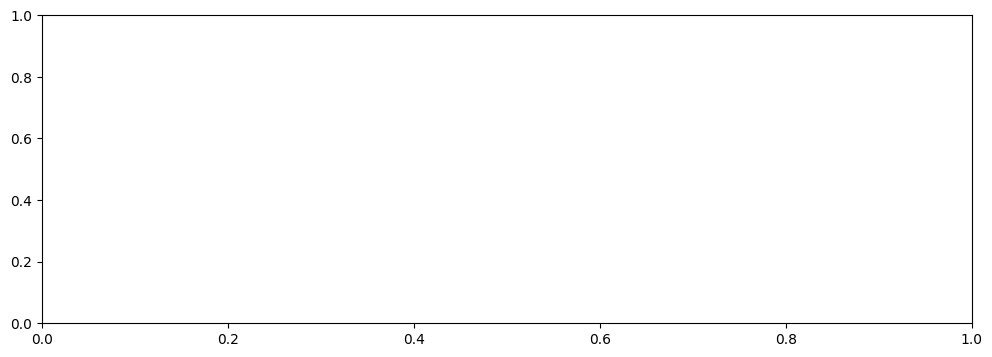

In [61]:
time = np.linspace(0, run_time, target_num_steps) * arista_nmf.timestep
plt.figure(figsize=(12, 4))

for sensor in arista_nmf._arista_sensors:
    plt.plot(time, sensor, label=sensor.name)
#plt.plot(time, arista_joint)

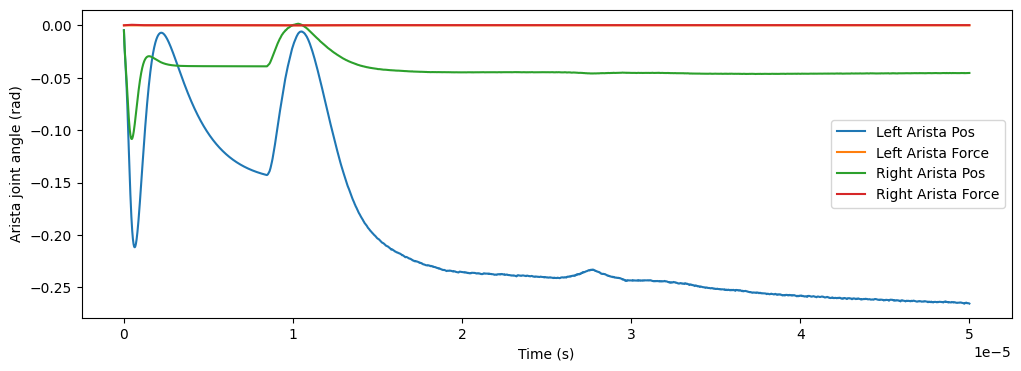

In [50]:
arista_joint = np.array([obs["arista_joint_pos"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps) * arista_nmf.timestep
plt.figure(figsize=(12, 4))

plt.plot(time, arista_joint)
plt.legend(["Left Arista Pos", "Left Arista Force","Right Arista Pos", "Right Arista Force"])
plt.xlabel("Time (s)")
plt.ylabel("Arista joint angle (rad)")
plt.show()